In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import random, copy
from collections import deque
from datetime import datetime
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [2]:
SEED_VALUE = 1993
BUFFER_CAPACITY = 1000000
T_LR = 0.001
BUFFER_FILL_MATCH_COUNT = 256
BEST_MATCHES_COUNT = 8
VARIATION_RANGE = 2
GAMMA = 0.995
BATCH_SIZE = 128
RACE_COUNT = 10
NUM_MODEL = 10
NUM_EPOCH = 10
FINAL_RACE_COUNT = 500
RACE_PERCENT = 20
BEST_N = 2

In [3]:
plot_path = "plots/Trainee_Multiplier_Model_1993_CartPole/"

In [4]:
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [5]:
# helper functions
def random_mul(val):
    '''
    gerates random number around 1
    val: deviation from 1
    '''
    return random.uniform(1 - val, 1 + val)

def max_two_index(l):
    m = sorted(l)
    n = m[-1]
    max_index_1 = [x for x in range(len(l)) if l[x] == n]
    o = [x for x in m if x != n]
    if len(o) == 0:
        return sorted(max_index_1)
    else:
        p = o[-1]
        max_index_2 = [x for x in range(len(l)) if l[x] == p]
        return sorted(max_index_1 + max_index_2)

def max_val_index(l):
    m = sorted(l)
    n = m[-1]
    max_index = [x for x in range(len(l)) if l[x] == n]
    return n, max_index[0]

def max_indices(l, length):
    m = list(set(l))
    n = sorted(m, reverse=True)
    o = min(length, len(n))
    p = n[:o]
    q = []
    for i in range(len(l)):
        for el in p:
            if el == l[i]:
                q.append(i)
    return sorted(list(set(q)))

def good_val_indices(l, percent, rank):
    m = max(l)
    n = min(l)
    o = m - (m - n) * (percent / 100)
    p1 = [i for i in range(len(l)) if l[i] == m]
    if len(p1) >= rank:
        return sorted(p1[:rank])
    q1 = [el for el in l if el != m]
    m1 = max(q1)
    p2 = [i for i in range(len(l)) if l[i] == m1][0]
    p = [i for i in range(len(l)) if o <= l[i] <= m]
    q = list(set(p).intersection(set([p2, p1[0]])))
    return sorted(q)

def biased_mean(l):
    if len(l) < 100:
        return 0
    else:
        return sum(l) / len(l)

def quad(x, r):
    return - 10 * ((x*x/(r+1))-x+1)

In [6]:
class Trainee:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self.nn_model()
        self.opt = tf.keras.optimizers.Adam(T_LR)

    def nn_model(self):
        inputs = Input((self.state_dim,))
        d1 = Dense(32, activation="relu")(inputs)
        d2 = Dense(32, activation="relu")(d1)
        outputs = Dense(1, activation="sigmoid")(d2)
        return tf.keras.Model(inputs, outputs)

    def get_action(self, state):
        state = np.array(state)
        predicted = self.model.predict(state)
        return 1 if predicted > 0.5 else 0

    def train(self, states, r_grads):
        r_grads = tf.convert_to_tensor(r_grads, dtype=tf.float32)
        with tf.GradientTape() as tape:
            x = self.model(states, training=True)
            grads = tape.gradient(x, self.model.trainable_variables, r_grads)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, info):
        self.buffer.append(info)

    def sample(self):
        sample = random.sample(self.buffer, BATCH_SIZE)
        states, r_grads = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(BATCH_SIZE, -1)
        r_grads = np.array(r_grads).reshape(BATCH_SIZE, -1)
        return states, r_grads

    def size(self):
        return len(self.buffer)

In [8]:
class Agent:
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.trs = [Trainee(self.state_dim) for _ in range(NUM_MODEL)]
        self.buffer = ReplayBuffer(BUFFER_CAPACITY)
        self.best_model = self.trs[0]

    def runners(self, model_list, weights, indices):
        delisted_indices = [i for i in range(NUM_MODEL) if i not in indices]
        for i in delisted_indices:
            updated_weights = [x * random_mul(VARIATION_RANGE) for x in weights]
            model_list[i].model.set_weights(updated_weights)
        return model_list

    def buffer_filler(self, best_model, index):
        temp_buffer_list = []
        ep_return_list = []
        for _ in range(BUFFER_FILL_MATCH_COUNT):
            ep_return = 0
            temp_buffer = []
            return_t = 0
            done = False
            state = self.env.reset()
            while not done:
                action = best_model.get_action([state])
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                ep_return += reward
                # r_grad = - (reward + (1 - GAMMA) * return_t) / (return_t + 0.1)
                x = reward + (1 - GAMMA) * return_t
                r_grad = quad(x, return_t)
                return_t = reward + GAMMA * return_t
                temp_buffer.append([state, r_grad])
            ep_return_list.append(ep_return)
            temp_buffer_list.append(temp_buffer)
        imp_index = max_indices(ep_return_list, BEST_MATCHES_COUNT)
        num_stored = 0
        for i in imp_index:
            for x in temp_buffer_list[i]:
                num_stored += 1
                self.buffer.store(x)
        for_plot = [ep_return_list[i] for i in imp_index]
        plt.plot(for_plot)
        plt.title(f"Buffer input Returns of race {index} with injection {num_stored}")
        plt.savefig(plot_path + f"buffer_returns_{index}.png")
        plt.show()
        
    def train_from_buffer(self, model_list):
        for m in model_list:
            for _ in range(NUM_EPOCH):
                states, r_grads = self.buffer.sample()
                m.train(states, r_grads)
    
    def race(self, model_list, index):
        race_avg = [0] * NUM_MODEL
        for i in range(NUM_MODEL):
            reward_sum = 0
            for _ in range(RACE_COUNT):
                done = False
                state = self.env.reset()
                while not done:
                    action = model_list[i].get_action([state])
                    next_state, reward, done, _ = self.env.step(action)
                    state = next_state
                    reward_sum += reward
            race_avg[i] = reward_sum / RACE_COUNT
        plt.plot(race_avg)
        plt.title(f"Racer Returns of race {index}")
        plt.savefig(plot_path + f"race_avg_returns_{index}.png")
        plt.show()
        return race_avg

    def train(self):
        i = 0
        for_plot = []
        ma = []
        model_list = self.trs
        while i < FINAL_RACE_COUNT and biased_mean(ma) < 200:
            print(f"Starting filling buffer: {i}...")
            self.buffer_filler(self.best_model, i)
            print("Training starts...")
            self.train_from_buffer(model_list)
            print(f"Buufer size: {self.buffer.size()}, Starting race {i}")
            race_avg = self.race(model_list, i)
            print("Race complete!")
            max_ep_reward, best_model_index = max_val_index(race_avg)
            good_model_indices = good_val_indices(race_avg, RACE_PERCENT, BEST_N)
            self.best_model = self.trs[best_model_index]
            for_plot.append(max_ep_reward)
            ma = for_plot[-(len(for_plot) if len(for_plot) < 100 else 100):]
            print(f"At race {i}, finalist model is Model#({best_model_index}) with episode reward {max_ep_reward}")
            print(f"carrying following Model numbers: {good_model_indices}")
            new_weights = model_list[best_model_index].model.get_weights()
            model_list = self.runners(model_list, new_weights, good_model_indices)
            i += 1
        plt.plot(for_plot)
        plt.title("Final Return Plot")
        plt.savefig(plot_path + "Final_Returns.png")
        plt.show()
        
    def get_final_weights(self):
        return self.best_model.model.get_weights()

Starts at 21-12-10, 11:16:55
Starting filling buffer: 0...


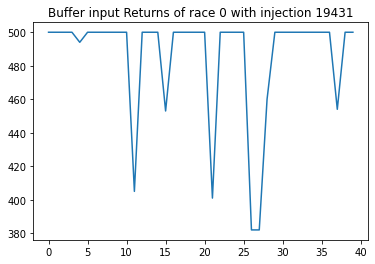

Training starts...
Buufer size: 19431, Starting race 0


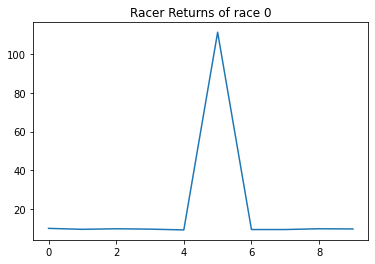

Race complete!
At race 0, finalist model is Model#(5) with episode reward 111.5
carrying following Model numbers: [5]
Starting filling buffer: 1...


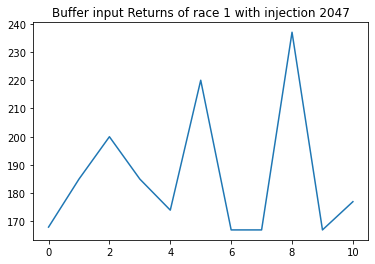

Training starts...
Buufer size: 21478, Starting race 1


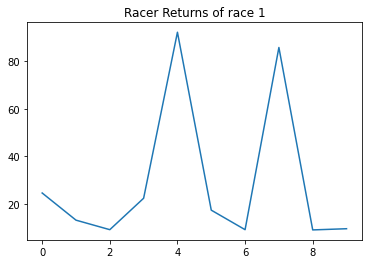

Race complete!
At race 1, finalist model is Model#(4) with episode reward 92.1
carrying following Model numbers: [4, 7]
Starting filling buffer: 2...


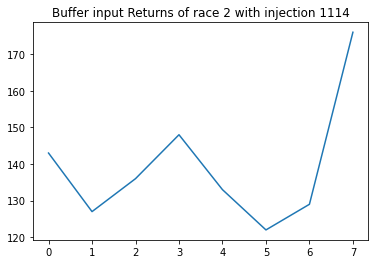

Training starts...
Buufer size: 22592, Starting race 2


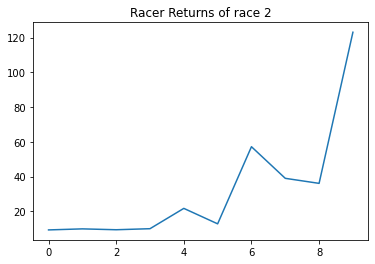

Race complete!
At race 2, finalist model is Model#(9) with episode reward 123.1
carrying following Model numbers: [9]
Starting filling buffer: 3...


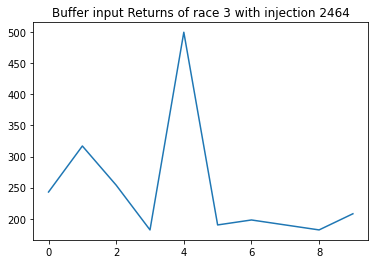

Training starts...
Buufer size: 25056, Starting race 3


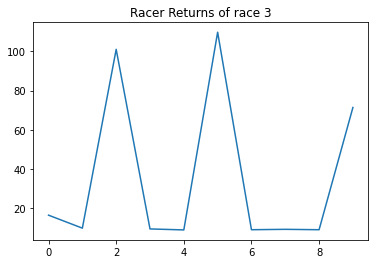

Race complete!
At race 3, finalist model is Model#(5) with episode reward 109.7
carrying following Model numbers: [2, 5]
Starting filling buffer: 4...


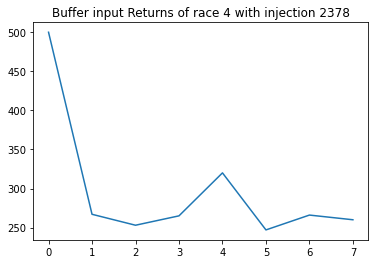

Training starts...
Buufer size: 27434, Starting race 4


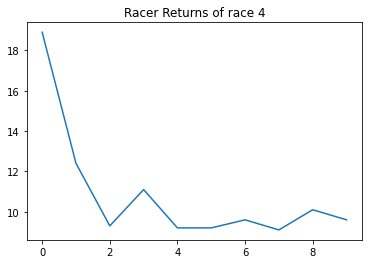

Race complete!
At race 4, finalist model is Model#(0) with episode reward 18.9
carrying following Model numbers: [0]
Starting filling buffer: 5...


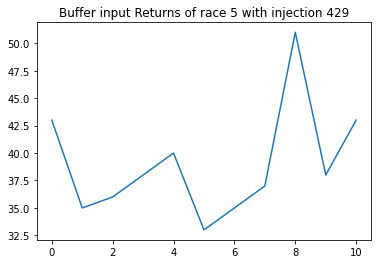

Training starts...
Buufer size: 27863, Starting race 5


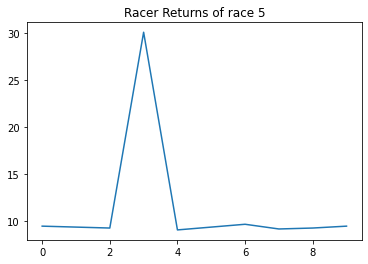

Race complete!
At race 5, finalist model is Model#(3) with episode reward 30.1
carrying following Model numbers: [3]
Starting filling buffer: 6...


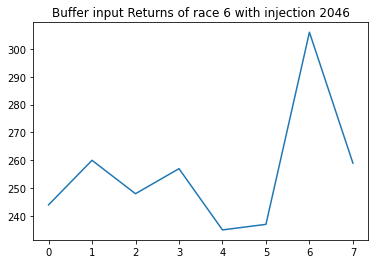

Training starts...
Buufer size: 29909, Starting race 6


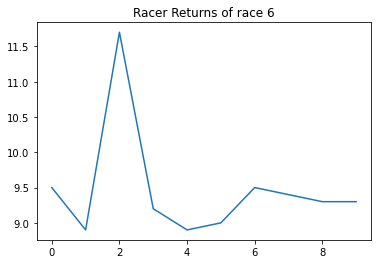

Race complete!
At race 6, finalist model is Model#(2) with episode reward 11.7
carrying following Model numbers: [2]
Starting filling buffer: 7...


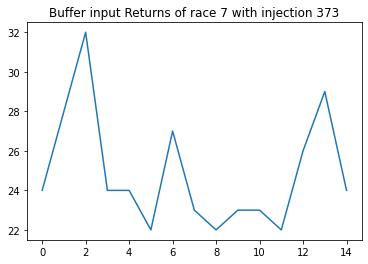

Training starts...
Buufer size: 30282, Starting race 7


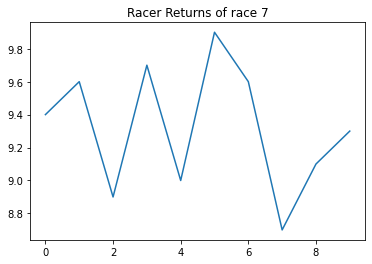

Race complete!
At race 7, finalist model is Model#(5) with episode reward 9.9
carrying following Model numbers: [3, 5]
Starting filling buffer: 8...


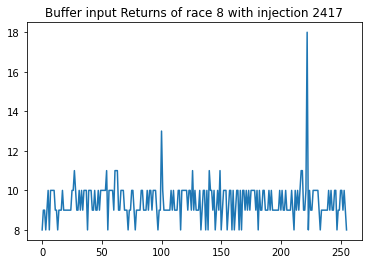

Training starts...
Buufer size: 32699, Starting race 8


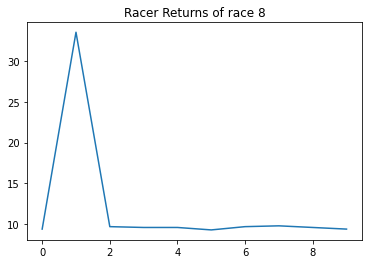

Race complete!
At race 8, finalist model is Model#(1) with episode reward 33.5
carrying following Model numbers: [1]
Starting filling buffer: 9...


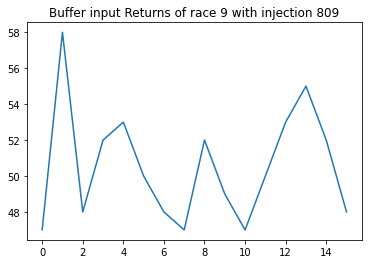

Training starts...
Buufer size: 33508, Starting race 9


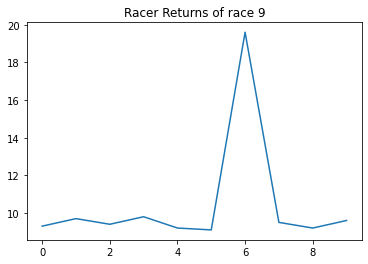

Race complete!
At race 9, finalist model is Model#(6) with episode reward 19.6
carrying following Model numbers: [6]
Starting filling buffer: 10...


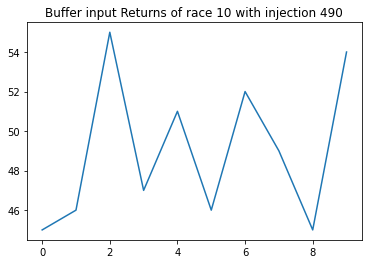

Training starts...
Buufer size: 33998, Starting race 10


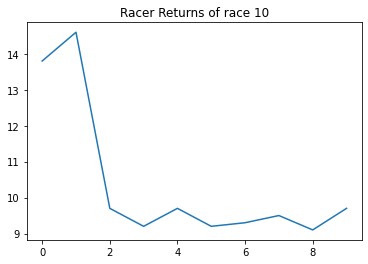

Race complete!
At race 10, finalist model is Model#(1) with episode reward 14.6
carrying following Model numbers: [0, 1]
Starting filling buffer: 11...


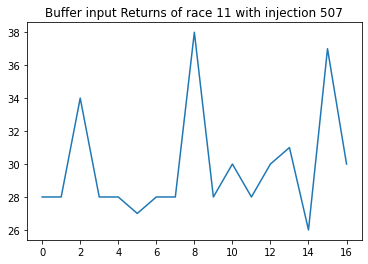

Training starts...
Buufer size: 34505, Starting race 11


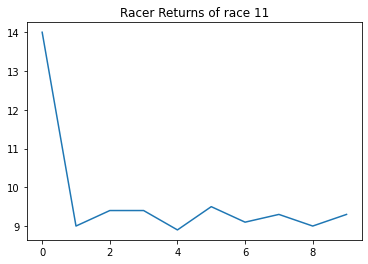

Race complete!
At race 11, finalist model is Model#(0) with episode reward 14.0
carrying following Model numbers: [0]
Starting filling buffer: 12...


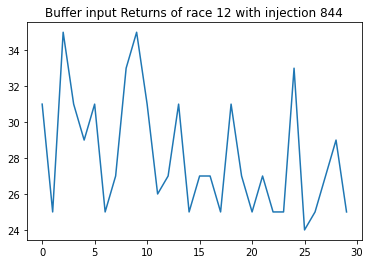

Training starts...
Buufer size: 35349, Starting race 12


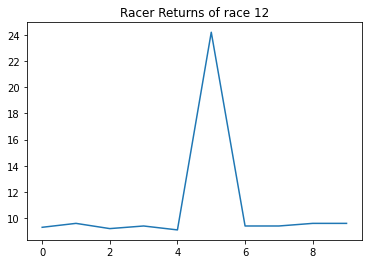

Race complete!
At race 12, finalist model is Model#(5) with episode reward 24.2
carrying following Model numbers: [5]
Starting filling buffer: 13...


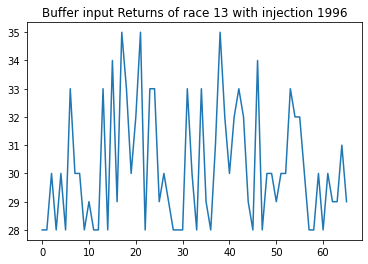

Training starts...
Buufer size: 37345, Starting race 13


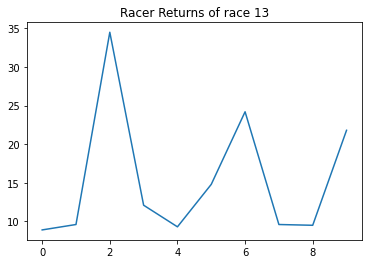

Race complete!
At race 13, finalist model is Model#(2) with episode reward 34.5
carrying following Model numbers: [2]
Starting filling buffer: 14...


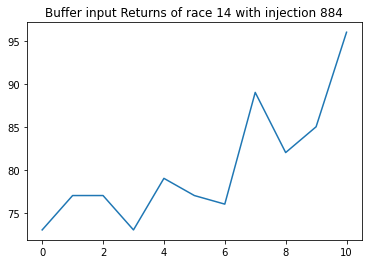

Training starts...
Buufer size: 38229, Starting race 14


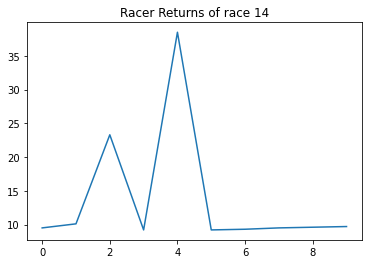

Race complete!
At race 14, finalist model is Model#(4) with episode reward 38.5
carrying following Model numbers: [4]
Starting filling buffer: 15...


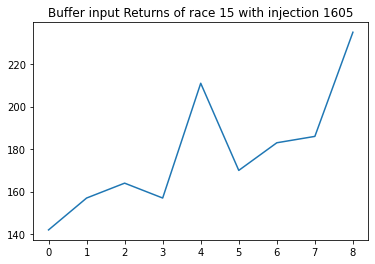

Training starts...
Buufer size: 39834, Starting race 15


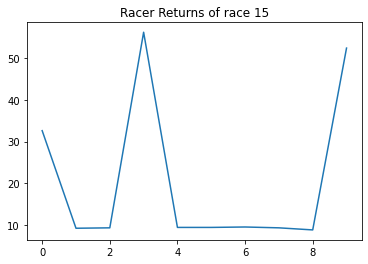

Race complete!
At race 15, finalist model is Model#(3) with episode reward 56.2
carrying following Model numbers: [3, 9]
Starting filling buffer: 16...


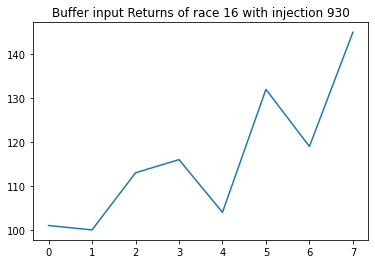

Training starts...
Buufer size: 40764, Starting race 16


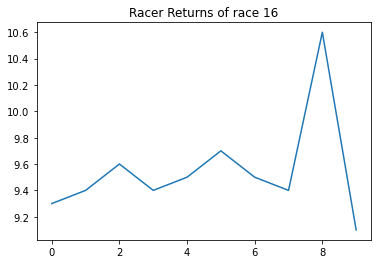

Race complete!
At race 16, finalist model is Model#(8) with episode reward 10.6
carrying following Model numbers: [8]
Starting filling buffer: 17...


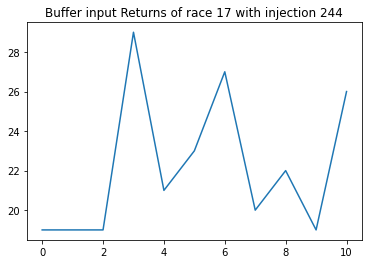

Training starts...
Buufer size: 41008, Starting race 17


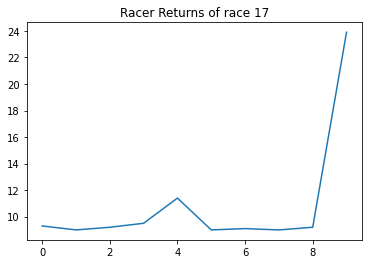

Race complete!
At race 17, finalist model is Model#(9) with episode reward 23.9
carrying following Model numbers: [9]
Starting filling buffer: 18...


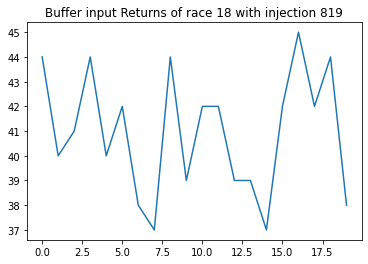

Training starts...
Buufer size: 41827, Starting race 18


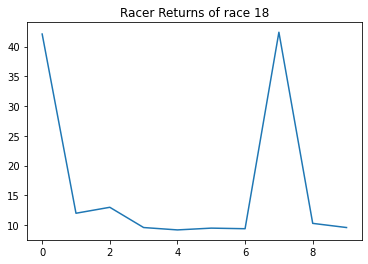

Race complete!
At race 18, finalist model is Model#(7) with episode reward 42.4
carrying following Model numbers: [0, 7]
Starting filling buffer: 19...


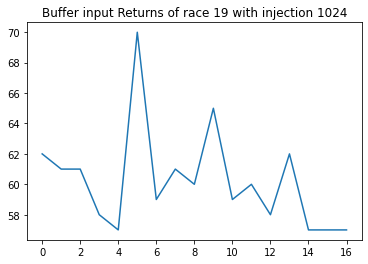

Training starts...
Buufer size: 42851, Starting race 19


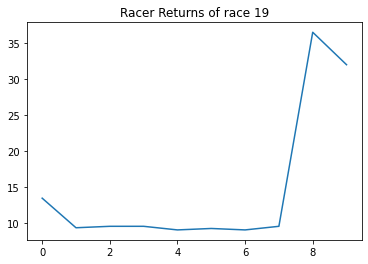

Race complete!
At race 19, finalist model is Model#(8) with episode reward 36.5
carrying following Model numbers: [8, 9]
Starting filling buffer: 20...


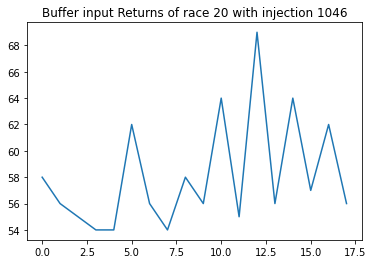

Training starts...
Buufer size: 43897, Starting race 20


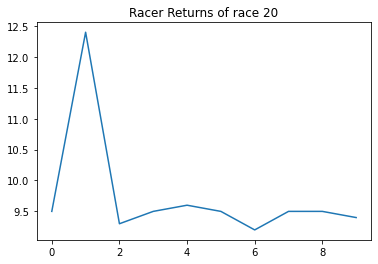

Race complete!
At race 20, finalist model is Model#(1) with episode reward 12.4
carrying following Model numbers: [1]
Starting filling buffer: 21...


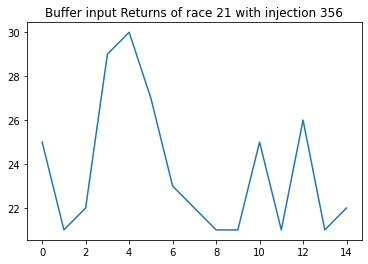

Training starts...
Buufer size: 44253, Starting race 21


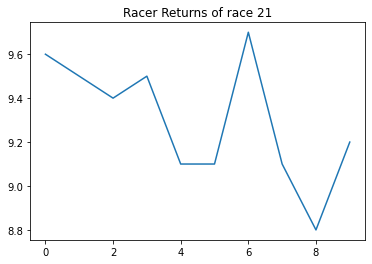

Race complete!
At race 21, finalist model is Model#(6) with episode reward 9.7
carrying following Model numbers: [0, 6]
Starting filling buffer: 22...


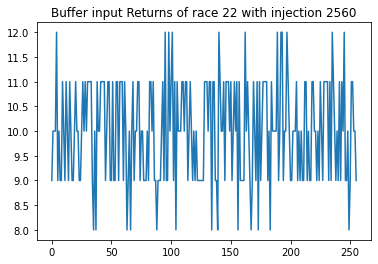

Training starts...
Buufer size: 46813, Starting race 22


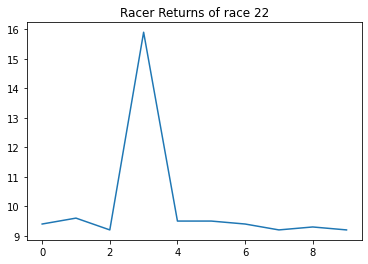

Race complete!
At race 22, finalist model is Model#(3) with episode reward 15.9
carrying following Model numbers: [3]
Starting filling buffer: 23...


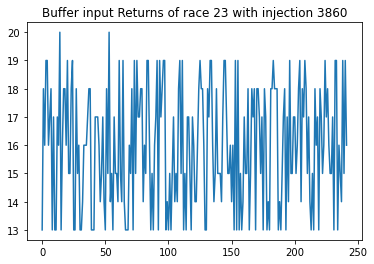

Training starts...
Buufer size: 50673, Starting race 23


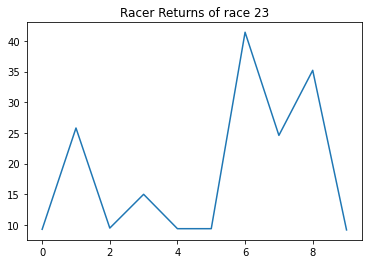

Race complete!
At race 23, finalist model is Model#(6) with episode reward 41.4
carrying following Model numbers: [6, 8]
Starting filling buffer: 24...


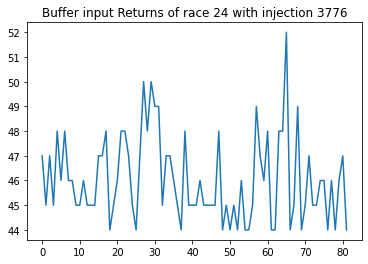

Training starts...
Buufer size: 54449, Starting race 24


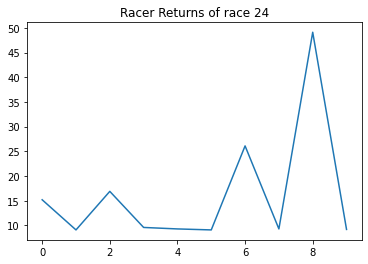

Race complete!
At race 24, finalist model is Model#(8) with episode reward 49.1
carrying following Model numbers: [8]
Starting filling buffer: 25...


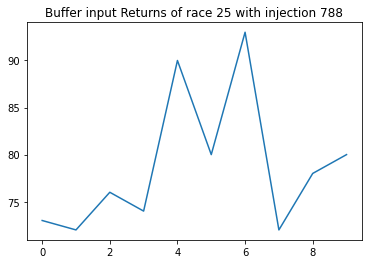

Training starts...
Buufer size: 55237, Starting race 25


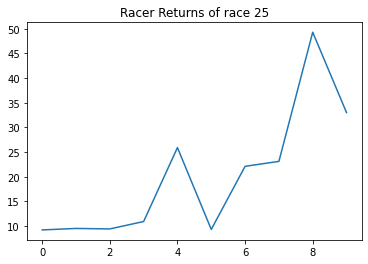

Race complete!
At race 25, finalist model is Model#(8) with episode reward 49.3
carrying following Model numbers: [8]
Starting filling buffer: 26...


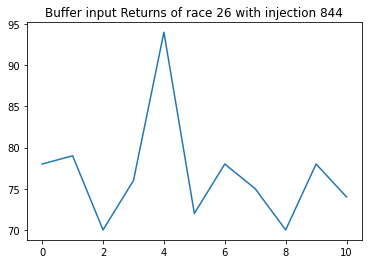

Training starts...
Buufer size: 56081, Starting race 26


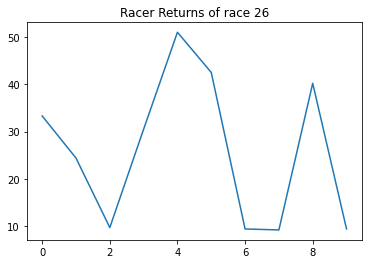

Race complete!
At race 26, finalist model is Model#(4) with episode reward 51.0
carrying following Model numbers: [4]
Starting filling buffer: 27...


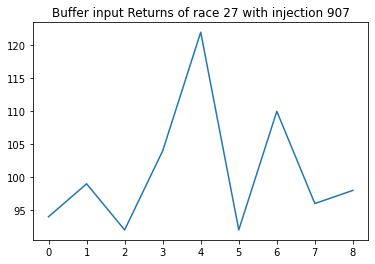

Training starts...
Buufer size: 56988, Starting race 27


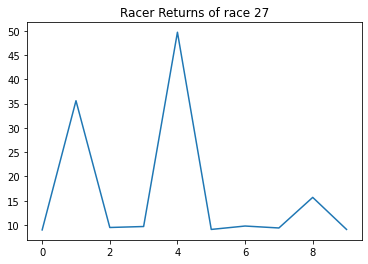

Race complete!
At race 27, finalist model is Model#(4) with episode reward 49.7
carrying following Model numbers: [4]
Starting filling buffer: 28...


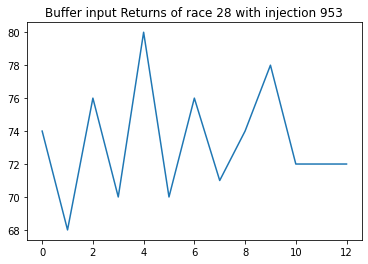

Training starts...
Buufer size: 57941, Starting race 28


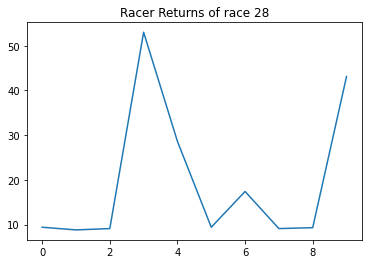

Race complete!
At race 28, finalist model is Model#(3) with episode reward 53.0
carrying following Model numbers: [3]
Starting filling buffer: 29...


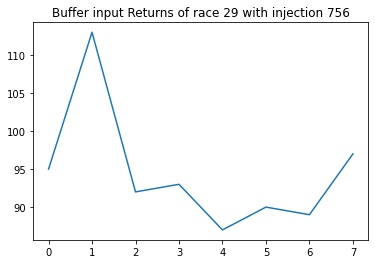

Training starts...
Buufer size: 58697, Starting race 29


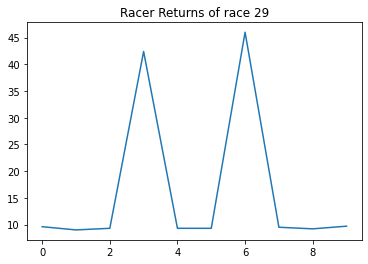

Race complete!
At race 29, finalist model is Model#(6) with episode reward 46.0
carrying following Model numbers: [3, 6]
Starting filling buffer: 30...


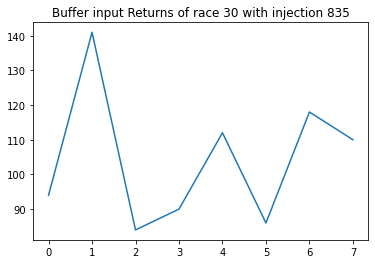

Training starts...
Buufer size: 59532, Starting race 30


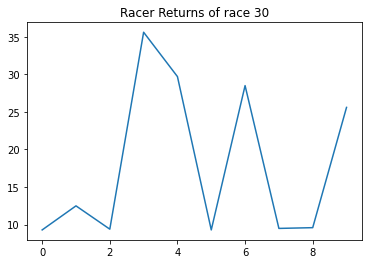

Race complete!
At race 30, finalist model is Model#(3) with episode reward 35.6
carrying following Model numbers: [3]
Starting filling buffer: 31...


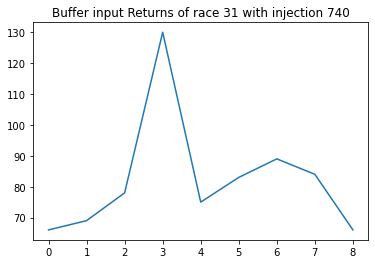

Training starts...
Buufer size: 60272, Starting race 31


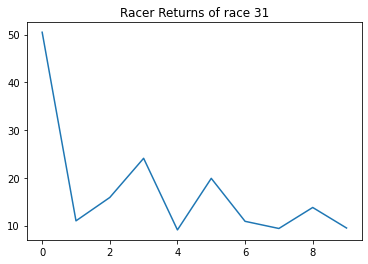

Race complete!
At race 31, finalist model is Model#(0) with episode reward 50.5
carrying following Model numbers: [0]
Starting filling buffer: 32...


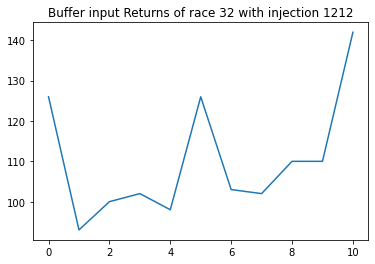

Training starts...
Buufer size: 61484, Starting race 32


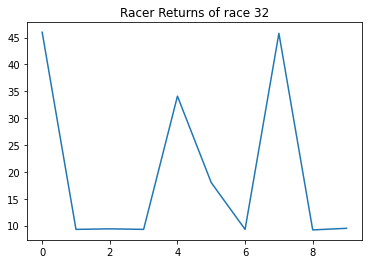

Race complete!
At race 32, finalist model is Model#(0) with episode reward 46.0
carrying following Model numbers: [0, 7]
Starting filling buffer: 33...


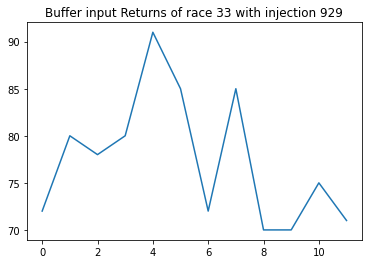

Training starts...
Buufer size: 62413, Starting race 33


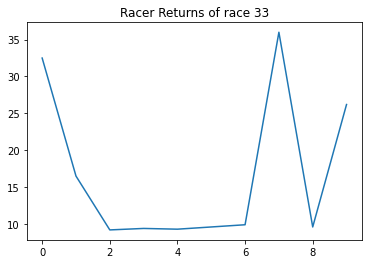

Race complete!
At race 33, finalist model is Model#(7) with episode reward 36.0
carrying following Model numbers: [0, 7]
Starting filling buffer: 34...


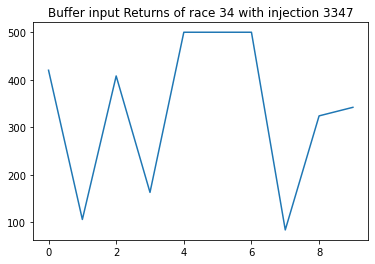

Training starts...
Buufer size: 65760, Starting race 34


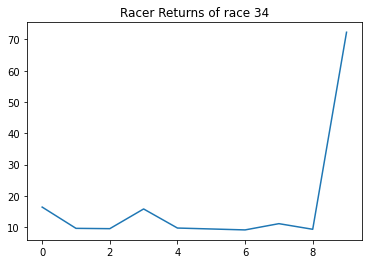

Race complete!
At race 34, finalist model is Model#(9) with episode reward 72.3
carrying following Model numbers: [9]
Starting filling buffer: 35...


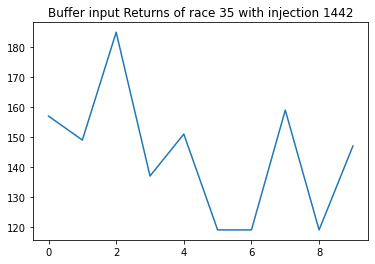

Training starts...
Buufer size: 67202, Starting race 35


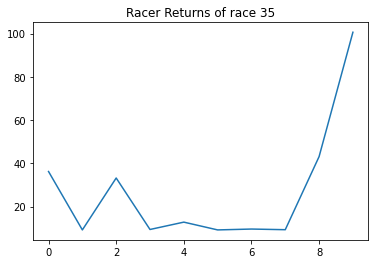

Race complete!
At race 35, finalist model is Model#(9) with episode reward 100.6
carrying following Model numbers: [9]
Starting filling buffer: 36...


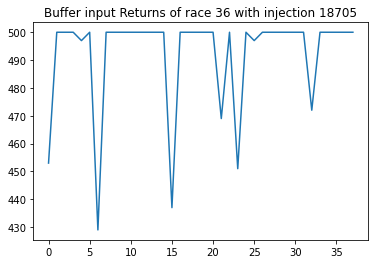

Training starts...
Buufer size: 85907, Starting race 36


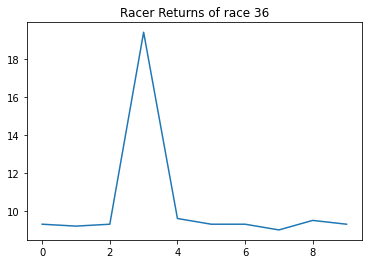

Race complete!
At race 36, finalist model is Model#(3) with episode reward 19.4
carrying following Model numbers: [3]
Starting filling buffer: 37...


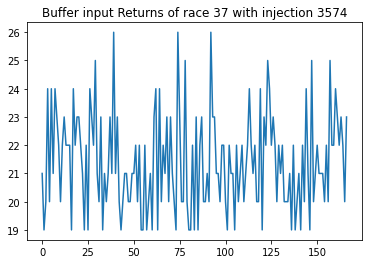

Training starts...
Buufer size: 89481, Starting race 37


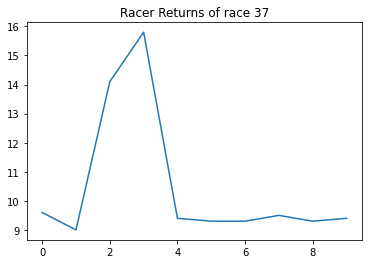

Race complete!
At race 37, finalist model is Model#(3) with episode reward 15.8
carrying following Model numbers: [3]
Starting filling buffer: 38...


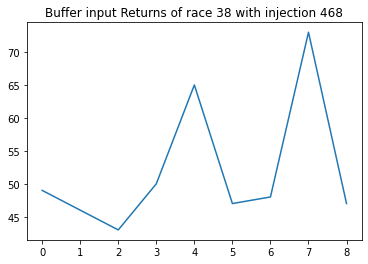

Training starts...
Buufer size: 89949, Starting race 38


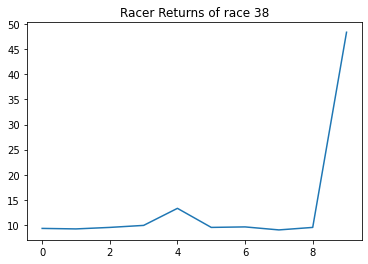

Race complete!
At race 38, finalist model is Model#(9) with episode reward 48.4
carrying following Model numbers: [9]
Starting filling buffer: 39...


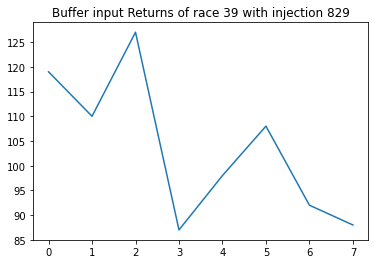

Training starts...
Buufer size: 90778, Starting race 39


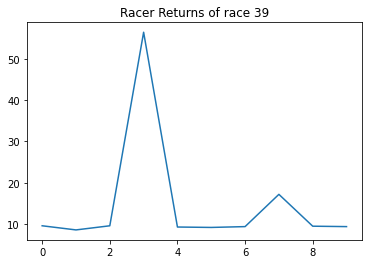

Race complete!
At race 39, finalist model is Model#(3) with episode reward 56.4
carrying following Model numbers: [3]
Starting filling buffer: 40...


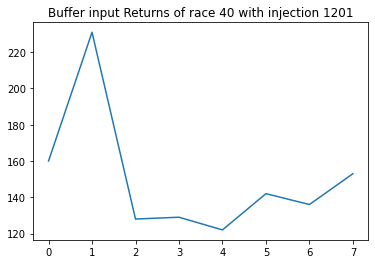

Training starts...
Buufer size: 91979, Starting race 40


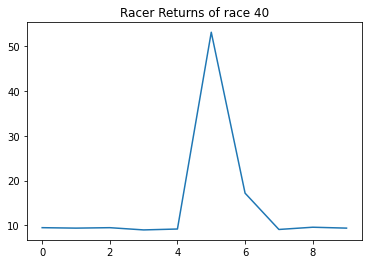

Race complete!
At race 40, finalist model is Model#(5) with episode reward 53.1
carrying following Model numbers: [5]
Starting filling buffer: 41...


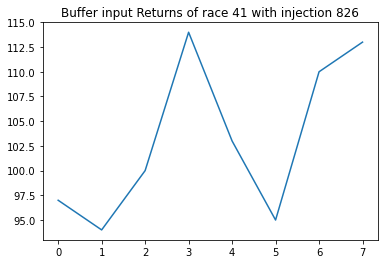

Training starts...
Buufer size: 92805, Starting race 41


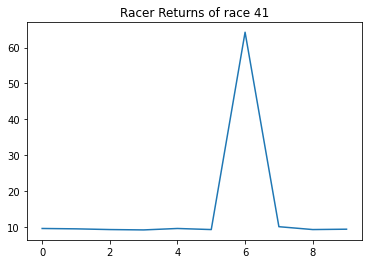

Race complete!
At race 41, finalist model is Model#(6) with episode reward 64.3
carrying following Model numbers: [6]
Starting filling buffer: 42...


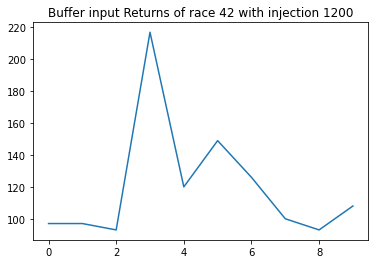

Training starts...
Buufer size: 94005, Starting race 42


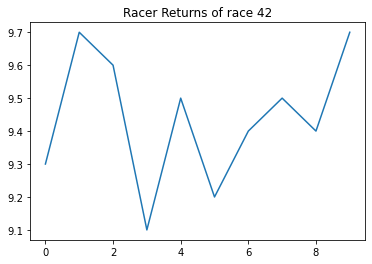

Race complete!
At race 42, finalist model is Model#(1) with episode reward 9.7
carrying following Model numbers: [1, 9]
Starting filling buffer: 43...


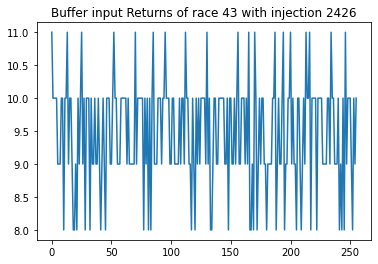

Training starts...
Buufer size: 96431, Starting race 43


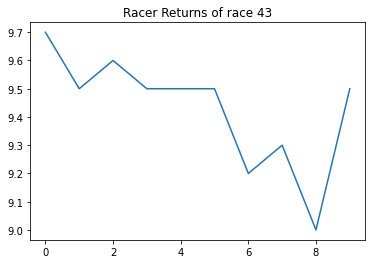

Race complete!
At race 43, finalist model is Model#(0) with episode reward 9.7
carrying following Model numbers: [0, 2]
Starting filling buffer: 44...


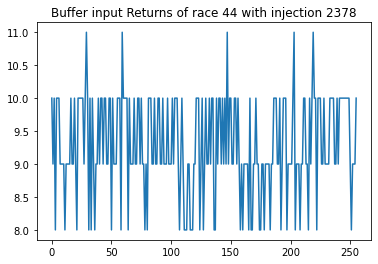

Training starts...
Buufer size: 98809, Starting race 44


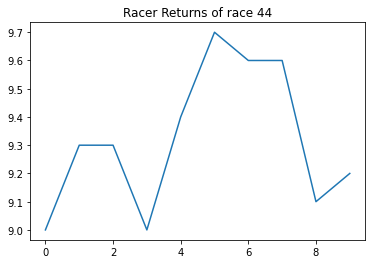

Race complete!
At race 44, finalist model is Model#(5) with episode reward 9.7
carrying following Model numbers: [5, 6]
Starting filling buffer: 45...


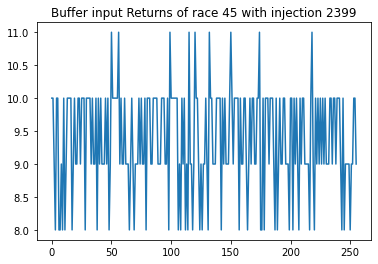

Training starts...
Buufer size: 101208, Starting race 45


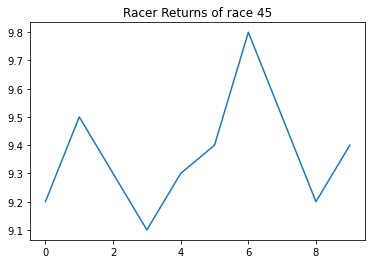

Race complete!
At race 45, finalist model is Model#(6) with episode reward 9.8
carrying following Model numbers: [6]
Starting filling buffer: 46...


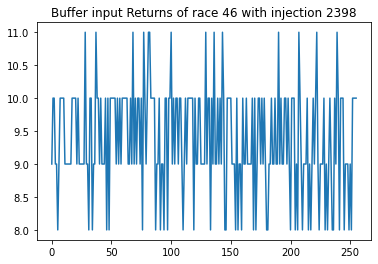

Training starts...
Buufer size: 103606, Starting race 46


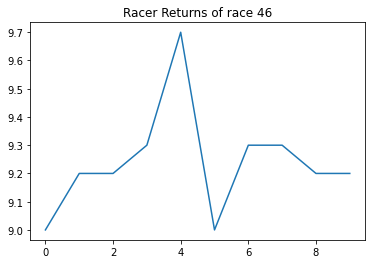

Race complete!
At race 46, finalist model is Model#(4) with episode reward 9.7
carrying following Model numbers: [4]
Starting filling buffer: 47...


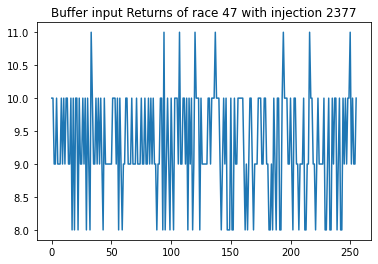

Training starts...
Buufer size: 105983, Starting race 47


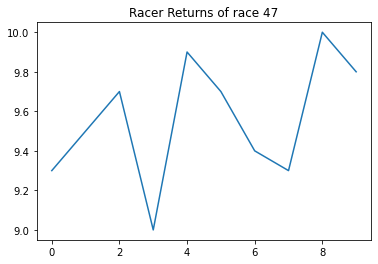

Race complete!
At race 47, finalist model is Model#(8) with episode reward 10.0
carrying following Model numbers: [4, 8]
Starting filling buffer: 48...


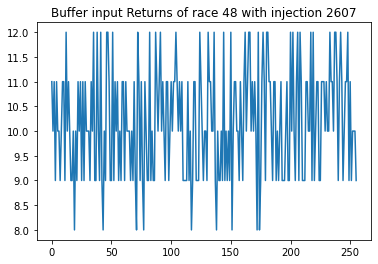

Training starts...
Buufer size: 108590, Starting race 48


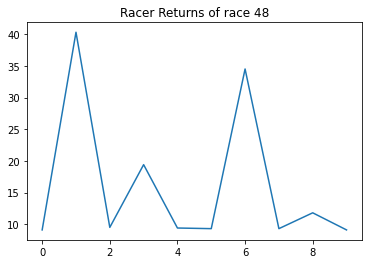

Race complete!
At race 48, finalist model is Model#(1) with episode reward 40.3
carrying following Model numbers: [1, 6]
Starting filling buffer: 49...


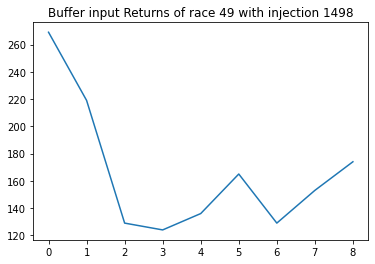

Training starts...
Buufer size: 110088, Starting race 49


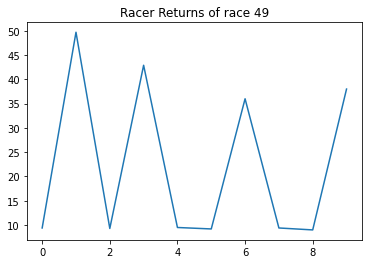

Race complete!
At race 49, finalist model is Model#(1) with episode reward 49.7
carrying following Model numbers: [1, 3]
Starting filling buffer: 50...


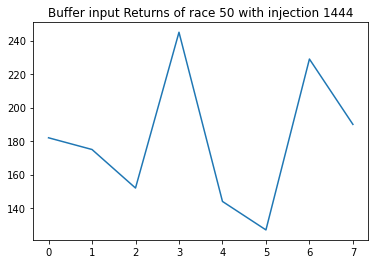

Training starts...
Buufer size: 111532, Starting race 50


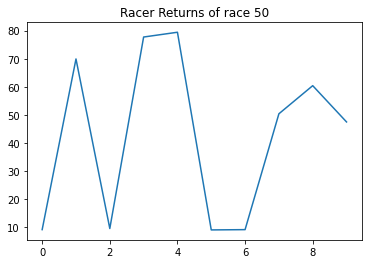

Race complete!
At race 50, finalist model is Model#(4) with episode reward 79.4
carrying following Model numbers: [3, 4]
Starting filling buffer: 51...


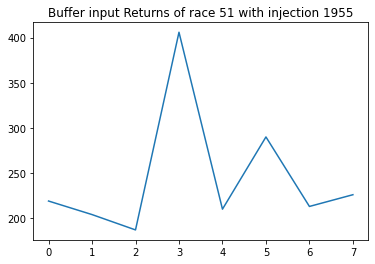

Training starts...
Buufer size: 113487, Starting race 51


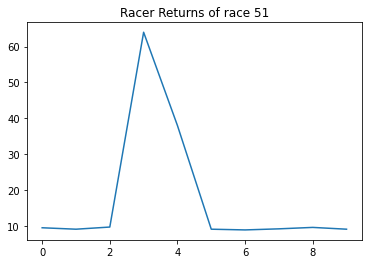

Race complete!
At race 51, finalist model is Model#(3) with episode reward 64.0
carrying following Model numbers: [3]
Starting filling buffer: 52...


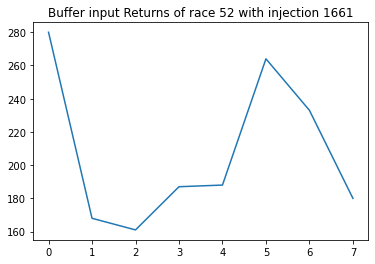

Training starts...
Buufer size: 115148, Starting race 52


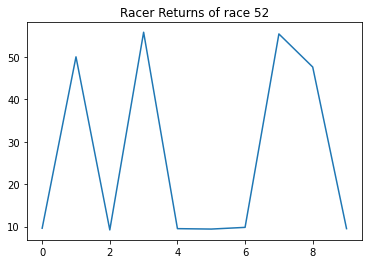

Race complete!
At race 52, finalist model is Model#(3) with episode reward 55.8
carrying following Model numbers: [3, 7]
Starting filling buffer: 53...


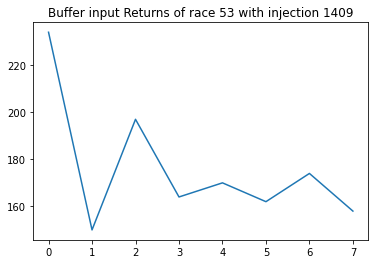

Training starts...
Buufer size: 116557, Starting race 53


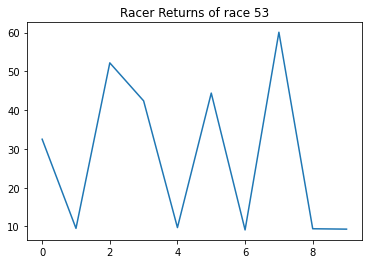

Race complete!
At race 53, finalist model is Model#(7) with episode reward 60.1
carrying following Model numbers: [2, 7]
Starting filling buffer: 54...


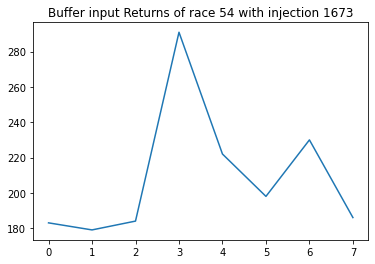

Training starts...
Buufer size: 118230, Starting race 54


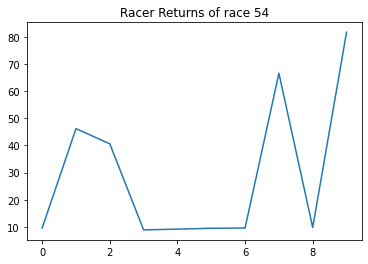

Race complete!
At race 54, finalist model is Model#(9) with episode reward 81.7
carrying following Model numbers: [9]
Starting filling buffer: 55...


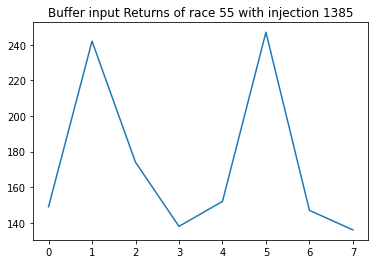

Training starts...
Buufer size: 119615, Starting race 55


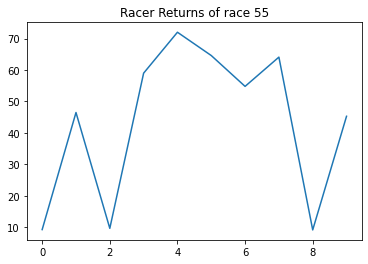

Race complete!
At race 55, finalist model is Model#(4) with episode reward 72.0
carrying following Model numbers: [4, 5]
Starting filling buffer: 56...


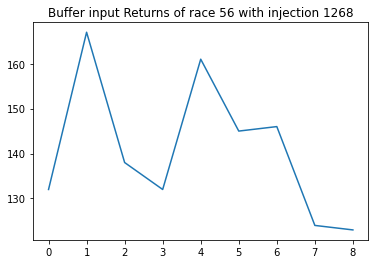

Training starts...
Buufer size: 120883, Starting race 56


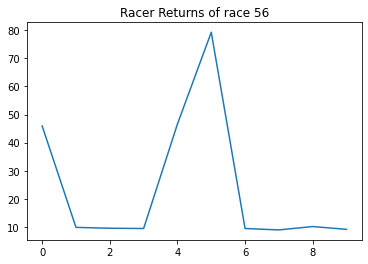

Race complete!
At race 56, finalist model is Model#(5) with episode reward 79.3
carrying following Model numbers: [5]
Starting filling buffer: 57...


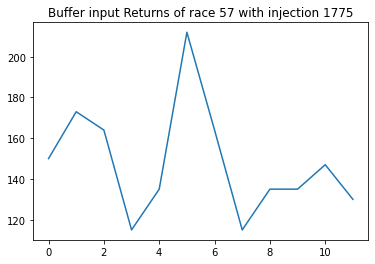

Training starts...
Buufer size: 122658, Starting race 57


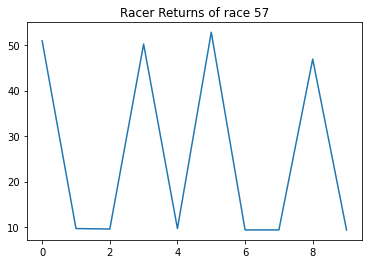

Race complete!
At race 57, finalist model is Model#(5) with episode reward 52.8
carrying following Model numbers: [0, 5]
Starting filling buffer: 58...


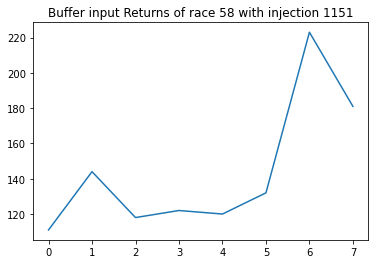

Training starts...
Buufer size: 123809, Starting race 58


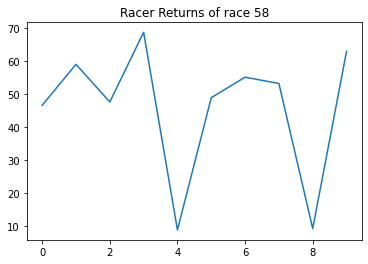

Race complete!
At race 58, finalist model is Model#(3) with episode reward 68.7
carrying following Model numbers: [3, 9]
Starting filling buffer: 59...


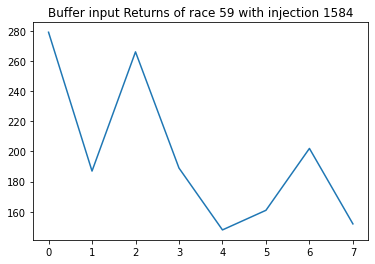

Training starts...
Buufer size: 125393, Starting race 59


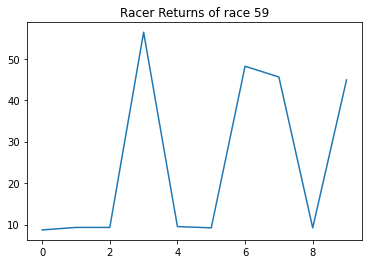

Race complete!
At race 59, finalist model is Model#(3) with episode reward 56.4
carrying following Model numbers: [3, 6]
Starting filling buffer: 60...


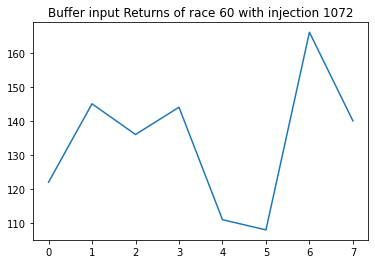

Training starts...
Buufer size: 126465, Starting race 60


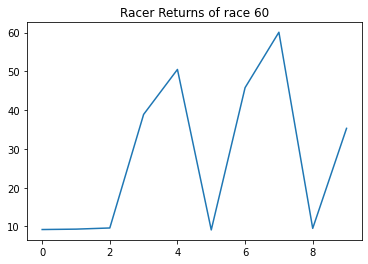

Race complete!
At race 60, finalist model is Model#(7) with episode reward 60.1
carrying following Model numbers: [4, 7]
Starting filling buffer: 61...


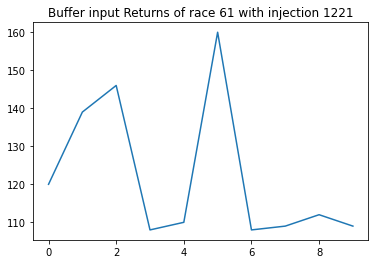

Training starts...
Buufer size: 127686, Starting race 61


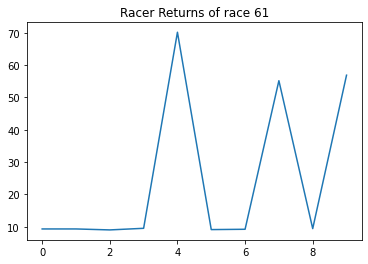

Race complete!
At race 61, finalist model is Model#(4) with episode reward 70.2
carrying following Model numbers: [4]
Starting filling buffer: 62...


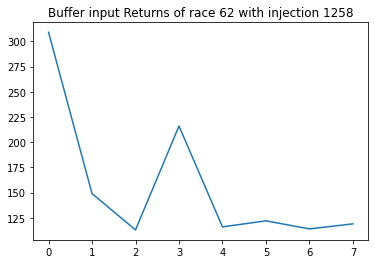

Training starts...
Buufer size: 128944, Starting race 62


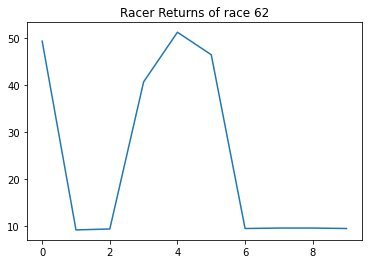

Race complete!
At race 62, finalist model is Model#(4) with episode reward 51.3
carrying following Model numbers: [0, 4]
Starting filling buffer: 63...


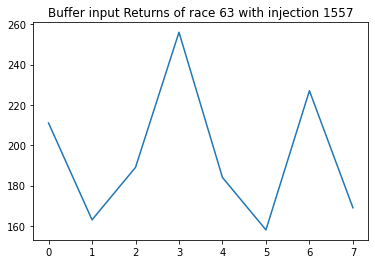

Training starts...
Buufer size: 130501, Starting race 63


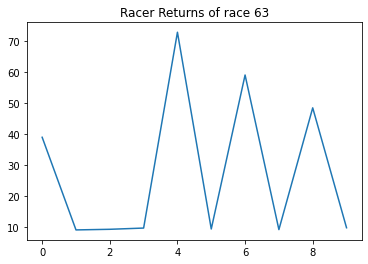

Race complete!
At race 63, finalist model is Model#(4) with episode reward 72.8
carrying following Model numbers: [4]
Starting filling buffer: 64...


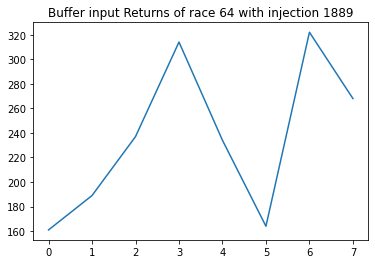

Training starts...
Buufer size: 132390, Starting race 64


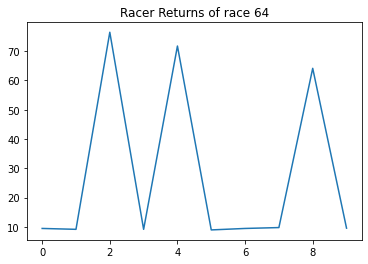

Race complete!
At race 64, finalist model is Model#(2) with episode reward 76.4
carrying following Model numbers: [2, 4]
Starting filling buffer: 65...


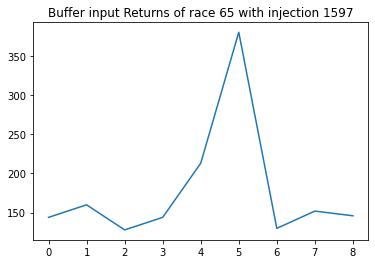

Training starts...
Buufer size: 133987, Starting race 65


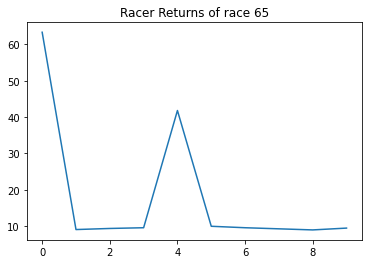

Race complete!
At race 65, finalist model is Model#(0) with episode reward 63.3
carrying following Model numbers: [0]
Starting filling buffer: 66...


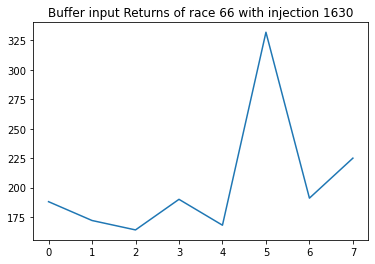

Training starts...
Buufer size: 135617, Starting race 66


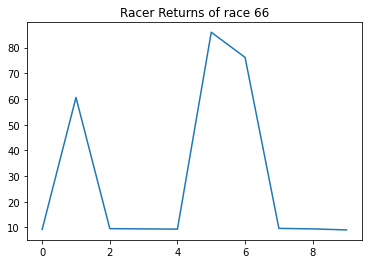

Race complete!
At race 66, finalist model is Model#(5) with episode reward 86.0
carrying following Model numbers: [5, 6]
Starting filling buffer: 67...


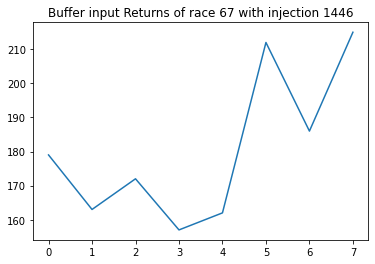

Training starts...
Buufer size: 137063, Starting race 67


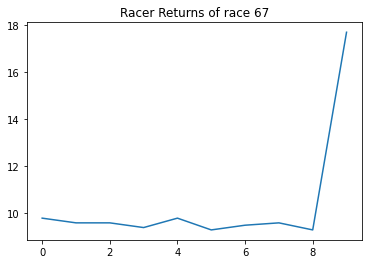

Race complete!
At race 67, finalist model is Model#(9) with episode reward 17.7
carrying following Model numbers: [9]
Starting filling buffer: 68...


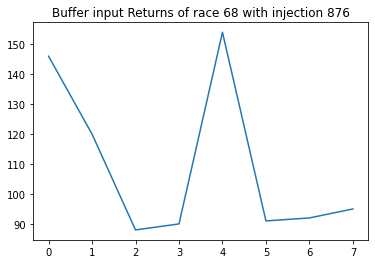

Training starts...
Buufer size: 137939, Starting race 68


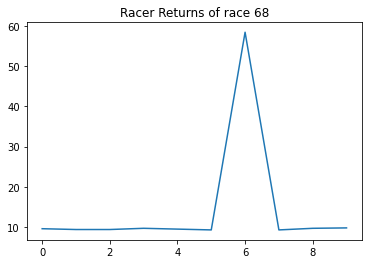

Race complete!
At race 68, finalist model is Model#(6) with episode reward 58.4
carrying following Model numbers: [6]
Starting filling buffer: 69...


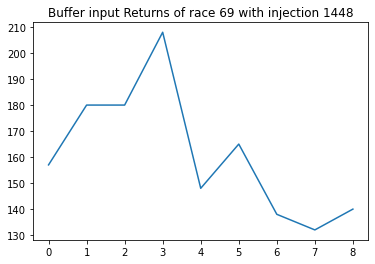

Training starts...
Buufer size: 139387, Starting race 69


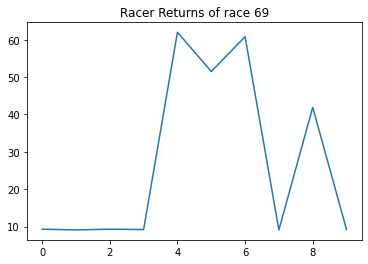

Race complete!
At race 69, finalist model is Model#(4) with episode reward 62.0
carrying following Model numbers: [4, 6]
Starting filling buffer: 70...


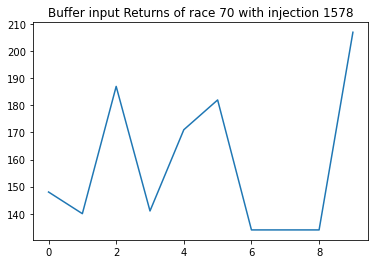

Training starts...
Buufer size: 140965, Starting race 70


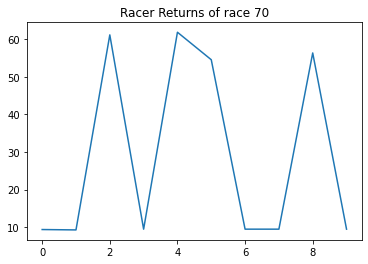

Race complete!
At race 70, finalist model is Model#(4) with episode reward 61.8
carrying following Model numbers: [2, 4]
Starting filling buffer: 71...


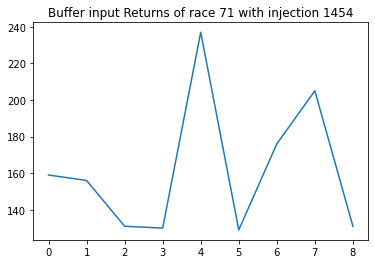

Training starts...
Buufer size: 142419, Starting race 71


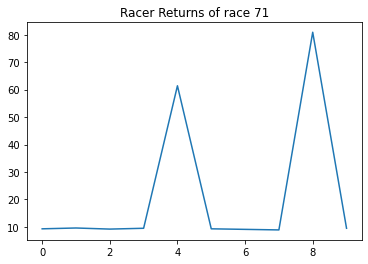

Race complete!
At race 71, finalist model is Model#(8) with episode reward 80.9
carrying following Model numbers: [8]
Starting filling buffer: 72...


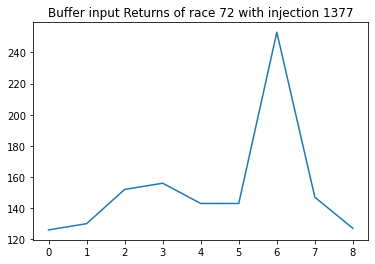

Training starts...
Buufer size: 143796, Starting race 72


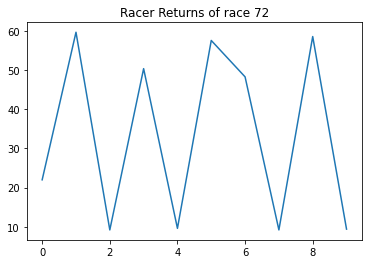

Race complete!
At race 72, finalist model is Model#(1) with episode reward 59.7
carrying following Model numbers: [1, 8]
Starting filling buffer: 73...


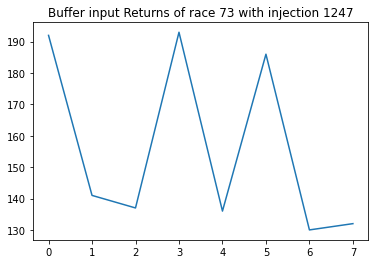

Training starts...
Buufer size: 145043, Starting race 73


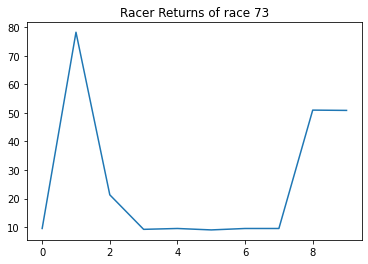

Race complete!
At race 73, finalist model is Model#(1) with episode reward 78.3
carrying following Model numbers: [1]
Starting filling buffer: 74...


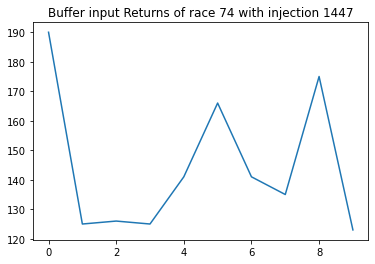

Training starts...
Buufer size: 146490, Starting race 74


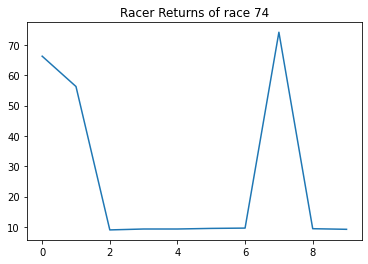

Race complete!
At race 74, finalist model is Model#(7) with episode reward 74.2
carrying following Model numbers: [0, 7]
Starting filling buffer: 75...


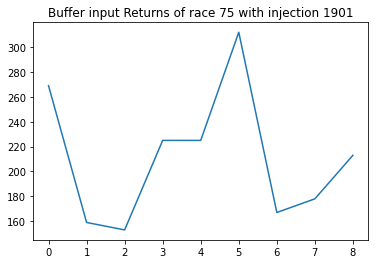

Training starts...
Buufer size: 148391, Starting race 75


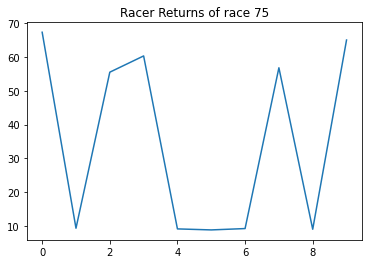

Race complete!
At race 75, finalist model is Model#(0) with episode reward 67.3
carrying following Model numbers: [0, 9]
Starting filling buffer: 76...


In [9]:
a = Agent("CartPole-v1")
print(f"Starts at {datetime.now().strftime('%y-%m-%d, %H:%M:%S')}")
a.train()
print(f"Ends at {datetime.now().strftime('%y-%m-%d, %H:%M:%S')}")